In [3]:
import pandas as pd

# Load the customer data from a CSV file
data = pd.read_csv('Customers.csv')


# Display basic statistics
print(data.describe())
print(data.info())


        CustomerID          Age  Annual Income ($)  Spending Score (1-100)  \
count  2000.000000  2000.000000        2000.000000             2000.000000   
mean   1000.500000    48.960000      110731.821500               50.962500   
std     577.494589    28.429747       45739.536688               27.934661   
min       1.000000     0.000000           0.000000                0.000000   
25%     500.750000    25.000000       74572.000000               28.000000   
50%    1000.500000    48.000000      110045.000000               50.000000   
75%    1500.250000    73.000000      149092.750000               75.000000   
max    2000.000000    99.000000      189974.000000              100.000000   

       Work Experience  Family Size  
count      2000.000000  2000.000000  
mean          4.102500     3.768500  
std           3.922204     1.970749  
min           0.000000     1.000000  
25%           1.000000     2.000000  
50%           3.000000     4.000000  
75%           7.000000     5.00

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Handle missing values
# Assuming numerical columns are filled with mean and categorical columns with the most frequent value
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations
data_preprocessed = preprocessor.fit_transform(data)

# Convert the preprocessed data back to a DataFrame
data_preprocessed_df = pd.DataFrame(data_preprocessed)

print(data_preprocessed_df.head())

         0         1         2         3         4         5    6    7    8   \
0 -1.731185 -1.054089 -2.093501 -0.428339 -0.791207  0.117497  0.0  1.0  0.0   
1 -1.729453 -0.983723 -1.656133  1.075546 -0.281162 -0.390051  0.0  1.0  0.0   
2 -1.727721 -1.018906 -0.540845 -1.609962 -0.791207 -1.405148  1.0  0.0  0.0   
3 -1.725989 -0.913356 -1.131292  0.932319 -1.046230 -0.897599  1.0  0.0  0.0   
4 -1.724257 -0.631891 -1.590528 -0.392532 -0.536185  1.132594  1.0  0.0  0.0   

    9    10   11   12   13   14   15   16  
0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  


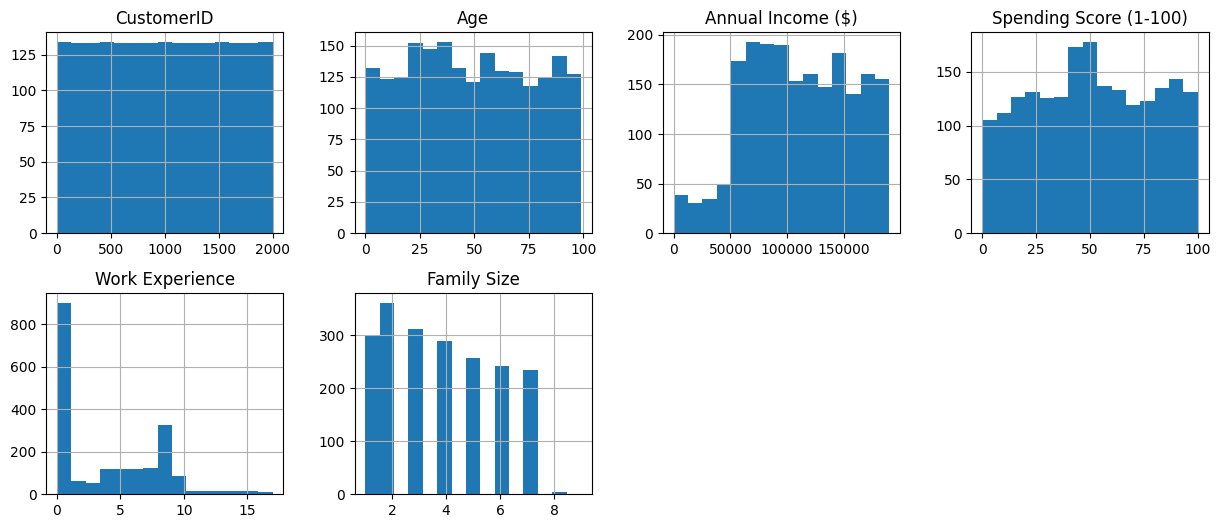

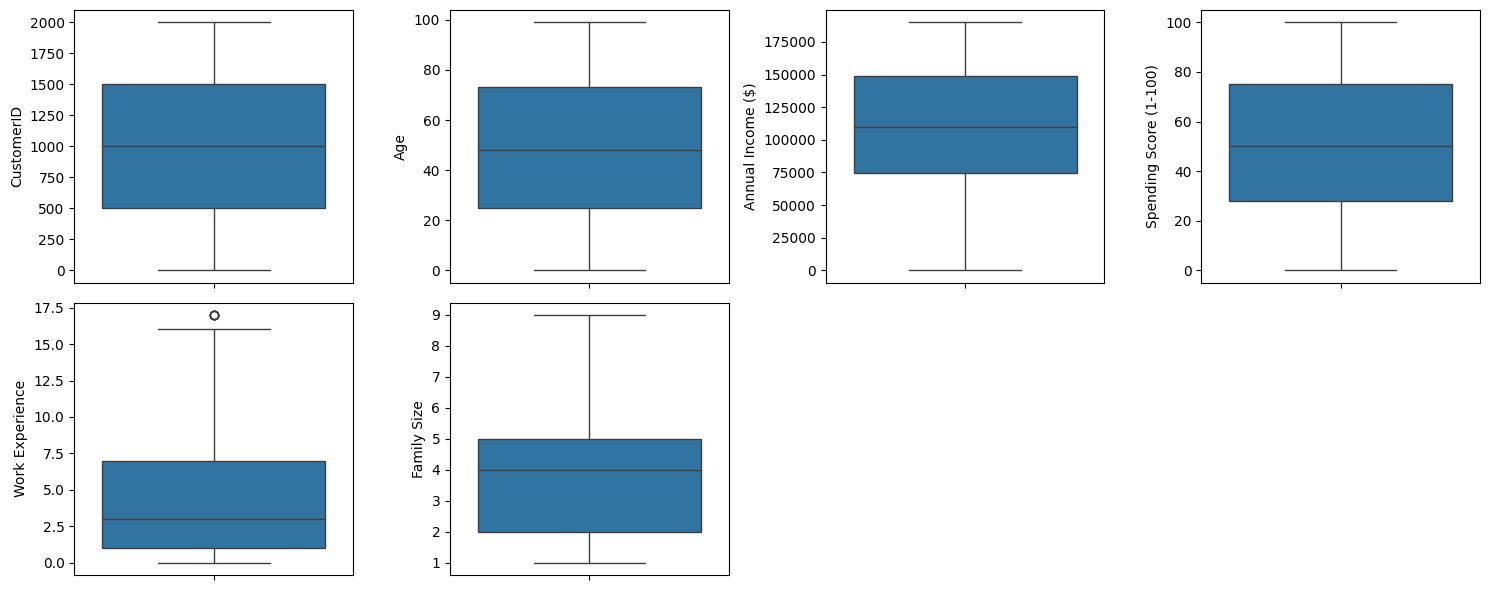

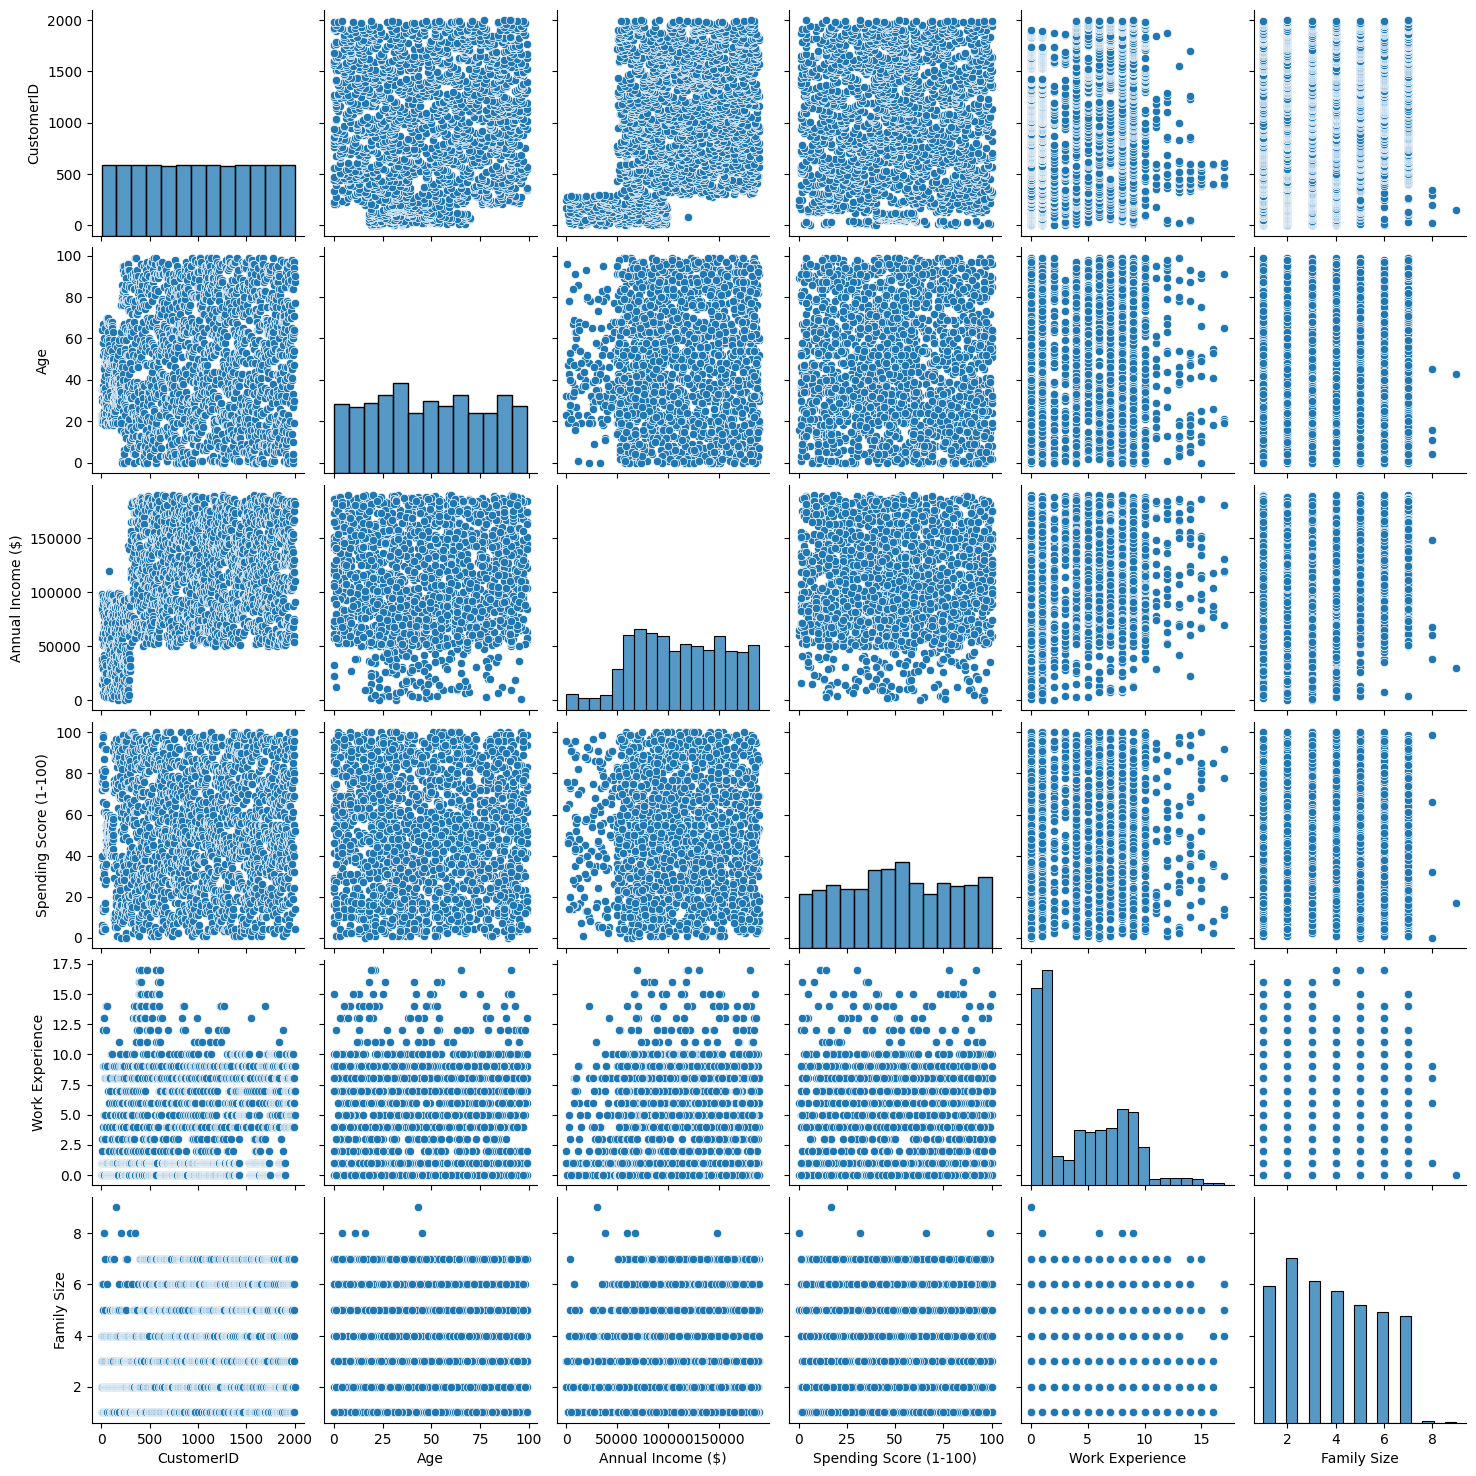

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for numerical features
data[numerical_features].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()

# Box plots for numerical features
plt.figure(figsize=(15, 6))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=data[col])
plt.tight_layout()
plt.show()

# Pair plots to examine feature correlations
sns.pairplot(data[numerical_features])
plt.show()

In [8]:
# Example: Creating a new feature 'Customer_Lifetime_Value'
# Calculate Total_Revenue as a proxy using Annual Income and Spending Score
data['Total_Revenue'] = data['Annual Income ($)'] * (data['Spending Score (1-100)'] / 100)

# Generate a Total_Orders column using Spending Score and Work Experience as a proxy
data['Total_Orders'] = data['Spending Score (1-100)'] / 10 + data['Work Experience']

# Calculate Customer Lifetime Value
data['Customer_Lifetime_Value'] = data['Total_Revenue'] / data['Age'].replace(0, 1)

# Calculate Average Purchase Frequency
data['Average_Purchase_Frequency'] = data['Total_Revenue'] / data['Total_Orders'].replace(0, 1)


# Display the first few rows of the updated DataFrame
print(data.head())

   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  Total_Revenue  Total_Orders  \
0     Healthcare                1            4         5850.0           4.9   
1       Engineer                3            3        28350.0          11.1   
2       Engineer                1            1         5160.0           1.6   
3         Lawyer                0            2        45430.0           7.7   
4  Entertainment                2            6        15200.0           6.0   

   Customer_Lifetime_Value  Average_Purchase_Frequency  
0               307.894737   

/Users/andremireles/opt/anaconda3/envs/Jpuenv/lib/python3.9/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


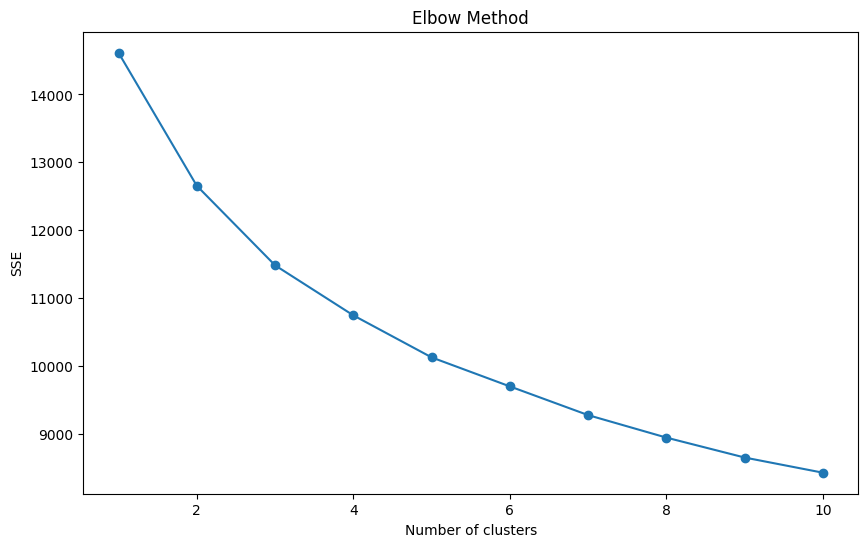

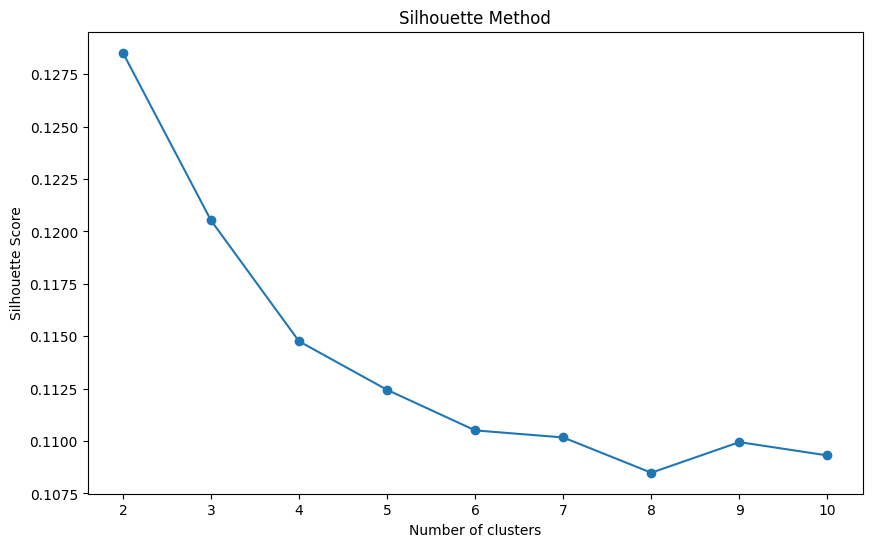

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_preprocessed)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Determine the optimal number of clusters using the Silhouette method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_preprocessed)
    score = silhouette_score(data_preprocessed, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  Total_Revenue  Total_Orders  \
0     Healthcare                1            4         5850.0           4.9   
1       Engineer                3            3        28350.0          11.1   
2       Engineer                1            1         5160.0           1.6   
3         Lawyer                0            2        45430.0           7.7   
4  Entertainment                2            6        15200.0           6.0   

   Customer_Lifetime_Value  Average_Purchase_Frequency  Cluster  
0               307.

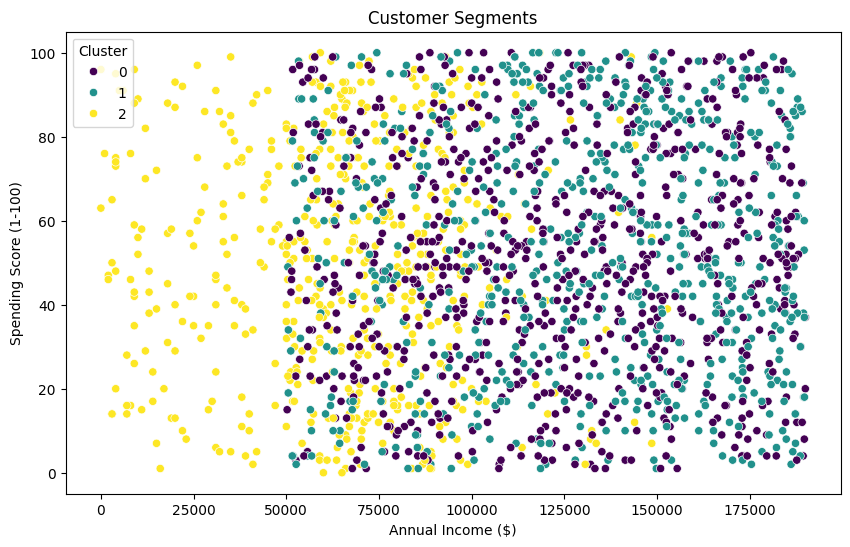

In [10]:
# Assuming the optimal number of clusters is determined to be 3 (replace with your optimal number)
optimal_clusters = 3

# Train the K-Means model
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_preprocessed)

# Display the first few rows of the DataFrame with cluster labels
print(data.head())

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Annual Income ($)'], y=data['Spending Score (1-100)'], hue=data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.show()

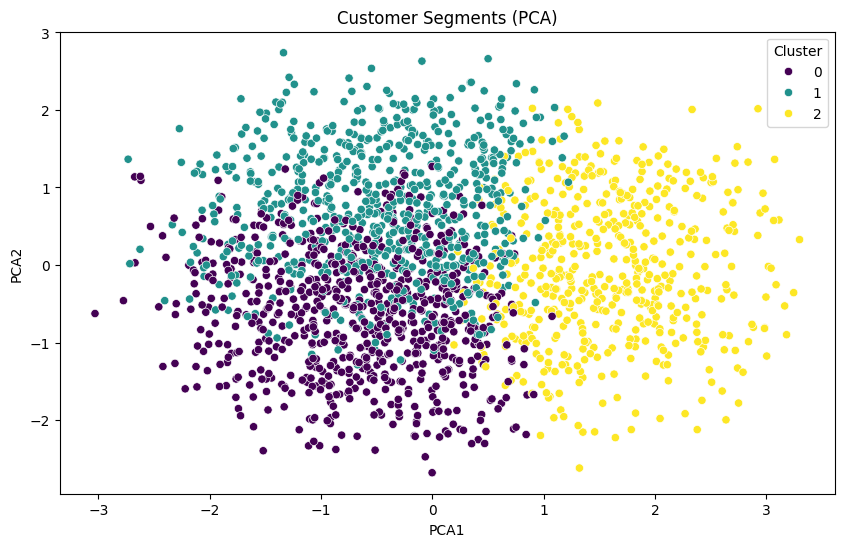

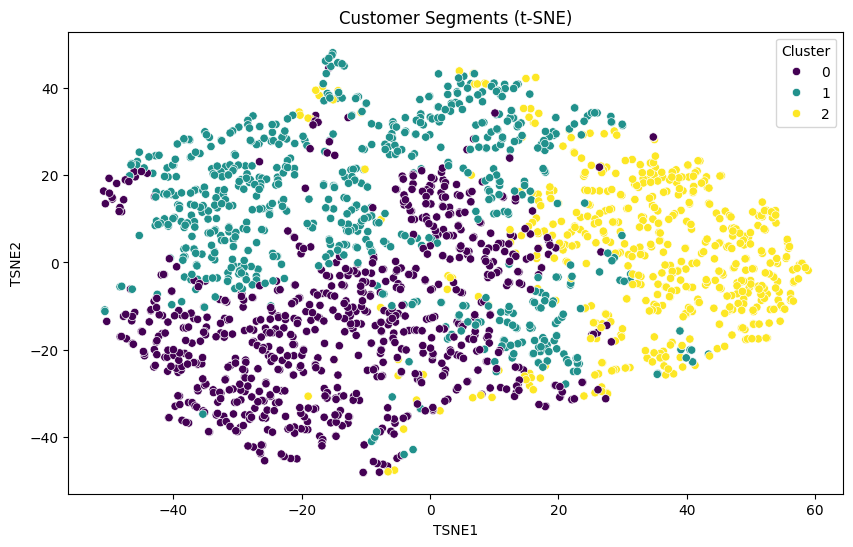

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Create a DataFrame with the PCA results
data_pca_df = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
data_pca_df['Cluster'] = data['Cluster']

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=data_pca_df, palette='viridis')
plt.title('Customer Segments (PCA)')
plt.show()

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data_preprocessed)

# Create a DataFrame with the t-SNE results
data_tsne_df = pd.DataFrame(data_tsne, columns=['TSNE1', 'TSNE2'])
data_tsne_df['Cluster'] = data['Cluster']

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=data_tsne_df, palette='viridis')
plt.title('Customer Segments (t-SNE)')
plt.show()

In [16]:
# Check for missing values in the Cluster column
if data['Cluster'].isnull().any():
    print("Warning: There are missing values in the 'Cluster' column.")
    data = data.dropna(subset=['Cluster'])

# Analyze the characteristics of each customer segment
# Select only numeric columns for the mean calculation
numeric_cols = data.select_dtypes(include='number').columns
segment_characteristics = data.groupby('Cluster')[numeric_cols].mean()
print("Segment Characteristics:\n", segment_characteristics)

# Document the characteristics of each segment
for cluster in segment_characteristics.index:
    print(f"Cluster {cluster} Characteristics:")
    print(segment_characteristics.loc[cluster])
    print("\n")

# Provide suggestions for targeted marketing strategies
marketing_strategies = {
    0: "High-value customers: Offer loyalty programs, exclusive discounts, and personalized services.",
    1: "Medium-value customers: Provide incentives for higher spending, such as bundled offers or discounts.",
    2: "Low-value customers: Focus on awareness campaigns and introductory offers to increase engagement."
}

# Verify cluster labels in the data
unique_clusters = data['Cluster'].unique()
print("Unique Clusters in Data:", unique_clusters)

# Ensure the marketing strategies dictionary covers all clusters
for cluster in unique_clusters:
    if cluster not in marketing_strategies:
        print(f"Warning: No marketing strategy defined for cluster {cluster}.")
    else:
        print(f"Cluster {cluster} Marketing Strategy: {marketing_strategies[cluster]}")

Segment Characteristics:
           CustomerID        Age  Annual Income ($)  Spending Score (1-100)  \
Cluster                                                                      
0        1241.727742  75.801290      123724.378065               50.612903   
1        1222.828035  22.693642      131021.455202               52.608382   
2         361.095685  44.033771       65497.941839               49.333959   

         Work Experience  Family Size  Total_Revenue  Total_Orders  \
Cluster                                                              
0               4.307097     4.143226   62683.908039      9.368387   
1               4.583815     4.088150   69040.119855      9.844653   
2               3.180113     2.808630   32087.657167      8.113508   

         Customer_Lifetime_Value  Average_Purchase_Frequency  Cluster  
Cluster                                                                
0                     858.969203                 7518.517014      0.0  
1               